<a href="https://colab.research.google.com/github/obeabi/Stats/blob/main/RandomDesign_CustomerServiceAB_Test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Analyzing AB Test Results

Use the data in Customer Service AB Testing Data file to perform an analysis on the following experiment and answer the questions that follows:

A call center for a cable internet provider wants to see if implementing an automated answering system to collect some data from the caller while they are on hold will increase customer service scores vs the customer service representative collecting that data after the customer has waited on hold. Twenty percent of the callers for the week of the experiment were randomly assigned to the treatment group and the rest were assigned to the control group. At the end of the call they were asked to fill out a one question survey. The data for the 1000 callers who took the survey is in the provided file.

In [25]:
!pip install pingouin

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [26]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind,chi2 , chi2_contingency
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 8) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

print('Libraries installed successfully!')

Libraries installed successfully!


In [27]:
# load dataset
df = pd.read_csv('customerserviceabtestdata.csv')

df.head()

,RecordID,Phone Number,AutomatedFlag,CS Rating
0,1,(733) 308-5171,1,2
1,2,(737) 479-9819,0,5
2,3,(571) 837-6630,0,4
3,4,(746) 481-2200,0,5
4,5,(224) 126-2105,1,4


In [28]:
# Inspect dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   RecordID       1000 non-null   int64 
 1   Phone Number   1000 non-null   object
 2   AutomatedFlag  1000 non-null   int64 
 3   CS Rating      1000 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 31.4+ KB


The sample size is fairly small with only 1000 responses. There could be some bias with voluntary responses.

In [29]:
# Check for missing values
df.isna().sum()

RecordID         0
Phone Number     0
AutomatedFlag    0
CS Rating        0
dtype: int64

In [30]:
# Inspect autofald column
df.AutomatedFlag.value_counts()

0    753
1    247
Name: AutomatedFlag, dtype: int64

In [31]:
# Change data type of RecordID and AutomatedFlag to string data type

df[['RecordID', 'AutomatedFlag']] = df[['RecordID', 'AutomatedFlag']].astype('str')

df.dtypes

RecordID         object
Phone Number     object
AutomatedFlag    object
CS Rating         int64
dtype: object

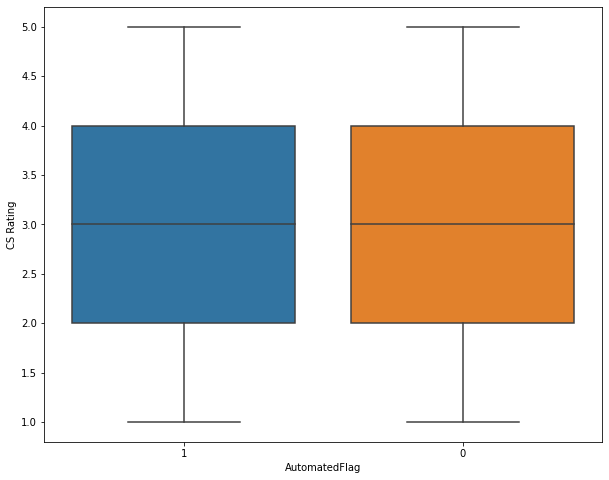

In [32]:
# Visualize counts in target variable
sns.boxplot(x='AutomatedFlag', y='CS Rating', data= df)
plt.show()

## Data Wrangling

In [33]:
# Extract useful columns
df1 = df[['Phone Number', 'AutomatedFlag', 'CS Rating']]
df1.head()

,Phone Number,AutomatedFlag,CS Rating
0,(733) 308-5171,1,2
1,(737) 479-9819,0,5
2,(571) 837-6630,0,4
3,(746) 481-2200,0,5
4,(224) 126-2105,1,4


In [34]:
## Estimate average value for any customers who called in more than once

df_grp = df1.groupby(['Phone Number', 'AutomatedFlag'], as_index= False).mean()
df_grp.head()

,Phone Number,AutomatedFlag,CS Rating
0,(100) 934-2262,1,5.0
1,(101) 638-972,0,1.0
2,(102) 174-9863,0,2.0
3,(102) 659-5138,1,5.0
4,(102) 704-680,0,2.0


In [35]:
# Dispaly shape of datatset
print(df_grp.shape)

(992, 3)


In [36]:
# Create group flag for users and automated vice system
df_grp['groups'] = np.where(df_grp.AutomatedFlag == '1', 'Test', 'Control')
df_grp.head()

,Phone Number,AutomatedFlag,CS Rating,groups
0,(100) 934-2262,1,5.0,Test
1,(101) 638-972,0,1.0,Control
2,(102) 174-9863,0,2.0,Control
3,(102) 659-5138,1,5.0,Test
4,(102) 704-680,0,2.0,Control


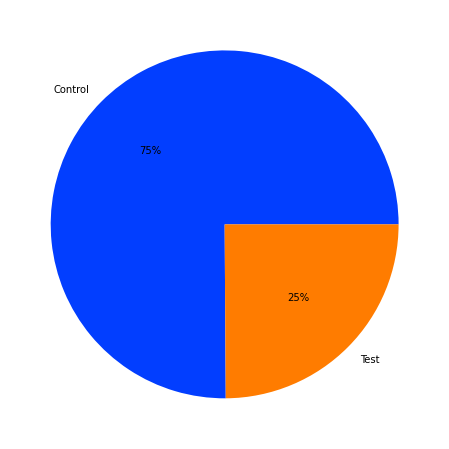

In [37]:
# Visualize counts in target variable
count_classes = pd.value_counts(df_grp['groups'], sort = True)
data = count_classes.values
keys  = count_classes.index
# define Seaborn color palette to use
palette_color = sns.color_palette('bright')
  
# plotting data on chart
plt.pie(data, labels=keys, colors=palette_color, autopct='%.0f%%')
  
# displaying chart
plt.show()

In [38]:
# Extract final dataset
df_test = df_grp[['groups', 'CS Rating']]
df_test.head()

,groups,CS Rating
0,Test,5.0
1,Control,1.0
2,Control,2.0
3,Test,5.0
4,Control,2.0


## Perform Test of Means (Ttest)

In [39]:
# Using pingouin library
data_group_test = df_test[df_test.groups == 'Test']. reset_index(drop = True)
data_group_control = df_test[df_test.groups == 'Control']. reset_index(drop = True)

result = pg.ttest(data_group_test['CS Rating'], data_group_control['CS Rating'], correction= True)

print(result)


               T         dof alternative     p-val        CI95%   cohen-d  \
T-test  1.918735  427.002161   two-sided  0.055684  [-0.0, 0.4]  0.139697   

         BF10     power  
T-test  0.497  0.476464  


In [40]:
ttest_ind(data_group_test['CS Rating'], data_group_control['CS Rating'], equal_var= False)

Ttest_indResult(statistic=1.9187350366094367, pvalue=0.05568424621474075)

In [41]:
# test OR treatment group statistics
data_group_test.describe().T

,count,mean,std,min,25%,50%,75%,max
CS Rating,247.0,3.255061,1.380661,1.0,2.0,3.0,4.0,5.0


In [42]:
# control grouptest statistics
data_group_control.describe().T

,count,mean,std,min,25%,50%,75%,max
CS Rating,745.0,3.059732,1.404003,1.0,2.0,3.0,4.0,5.0


##Interpreting the result

The p-value of the test comes out to be > significance level alpha (that is, 0.05). This implies that we cannot reject the null hypotheisis H0 i.e. we are not statiscticaly confident that the difference in means from both the control group and treatment group is not random. Also, the Cohen’s D that is obtained in a t-test is in terms of the relative strength. According to Cohen:

cohen-d = 0.2 is considered as the ‘small’ effect size cohen-d = 0.5 is considered as the ‘medium’ effect size cohen-d = 0.8 is considered as the ‘large’ effect size

Therefore, Cohen’s d characterizes the effect size by relating the mean difference to variability, similar to a signal-to-noise ratio. A large Cohen’s d indicates the mean difference (effect size = signal) is large compared to the variability (noise). Conversely, a small Cohen's d indicates the mean difference (effectsize = signal) is small compared to the variability (noise).

In summary, the p-value is above .05, which suggests there isn’t enough evidence to say that the automated system affects the CS score. However, due to the low sample size, I would suggest to conduct the experiment again for a longer period of time to gather more data.